# Plots of warning products and observations for TC Japser

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import shapefile as shp

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatch

# local modules
import my_functions as mf
import gamma_fitting as gf


In [2]:
DIR_DATA = 'data'

# AEP percentage thresholds for MOD+, SEV+, EXT
AEP_PCTS = [20, 10, 5]

PROB_THRESHOLDS = [.1, .3, .5]

# thresholds of severity categories, expressed as variables in the gridded AEP dataset
SEV_THRESHOLDS = ['depth_01440min_020aep', 'depth_01440min_010aep', 'depth_01440min_005aep']

# places on the plot
PLACES = pd.DataFrame({
    'name': ['Cooktown', 'Cairns', 'Ingham', 'Townsville', 'Georgetown', 'Port Douglas'],
    'lat': [-15.4666648, -16.925491, -18.651112, -19.258965, -18.298, -16.4835],
    'lon': [145.2833322, 145.754120, 146.154617, 146.816956, 143.548, 145.4652]
})

# domain of interest, in Albers equal area projection coordinates
XLIMS = (1.06e6, 1.76e6)
YLIMS = (-2.15e6, -1.45e6)

# colours for warning levels and water
C_WATER = "#abd9e9"
C_NIL = "white"
C_YELLOW = "#fae04a"
C_ORANGE = "#fc7a26"
C_RED = "#d60d26"


DAY2_SCALING = np.array(
    [
        [1, 1, 1],  # Very likely row
        [1, 1, 1],  # Likely row
        [1, 1, 1],  # Possible row
    ]
)

DAY1_SCALING = np.array(
    [
        [1, 2, 3],  # Very likely row
        [1, 2, 2],  # Likely row
        [1, 1, 1],  # Possible row
    ]
)

DAY0_SCALING = np.array(
    [
        [2, 3, 3],  # Very likely row
        [1, 2, 3],  # Likely row
        [1, 1, 2],  # Possible row
    ]
)

In [3]:
# the GFE shape file for public weather districts
sf = shp.Reader(f'{DIR_DATA}/gfe_shape_files/gfe_public_weather.shp')

## Map of observed severity categories

In [4]:
# get AEP thresholds in millimetres at each station
aeps_stns = xr.open_dataset(f'{DIR_DATA}/aeps_at_stations.nc').sel(aep_pct=AEP_PCTS)['rainfall_depth']

# get the observations
obs = pd.read_csv(f'{DIR_DATA}/observations.csv')

# we will plot the observation map in Albers equal area coords
obs['projection_x_coordinate'], obs['projection_y_coordinate'] = mf.latlon_to_albers(obs.latitude, obs.longitude)

# get the severity level of the observations
# 0 = NIL, 1 = MOD, 2 = SEV, 3 = EXT
obs_level = obs[['station_number', 'precip']].set_index('station_number').to_xarray()['precip']
obs_level = (obs_level > aeps_stns).sum('aep_pct').rename('obs_level').to_dataframe()
obs = obs.merge(obs_level, on='station_number')

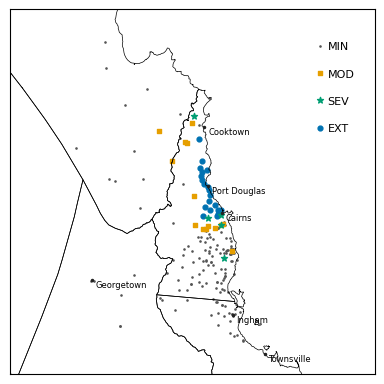

In [5]:
fig, ax = plt.subplots()

n_levels = 4


mf.add_public_wx_districts(sf, 'black')

# add place names
# displace place name labels
place_label_x_delta = 7e3
places = PLACES.copy()
# first get lat lon of places in projection coordinates
places_x, places_y = mf.latlon_to_albers(places['lat'], places['lon'])
ax.plot(places_x, places_y, marker='.', c='#222222', markersize=3, linestyle='None', label='Points')
for i in range(len(places)):
    ax.text(places_x[i] + place_label_x_delta, places_y[i], places['name'][i], 
            fontsize=6, horizontalalignment="left", verticalalignment="top")

# colours, shapes and size for different observed levels
level_colors = ["#555555", "#E69F00", "#009E73", "#0072B2"]
level_shapes = [".", "s", "*", "o"]
level_sizes = [3, 6, 20, 12]
for i in [0, 1, 3, 2]:
    obs0 = obs[obs.obs_level == i]

    ax.scatter(
        obs0['projection_x_coordinate'].values, 
        obs0['projection_y_coordinate'].values, 
        c=level_colors[i],
        s=level_sizes[i],
        marker=level_shapes[i]
    )

# plot in domain of interest
ax.set_xlim(*XLIMS)
ax.set_ylim(*YLIMS)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
)
plt.tick_params(
    axis='y',          # changes apply to the y-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False
)

# manually add legend
x_pos = [mf.get_pos(.85, XLIMS) for i in range(n_levels)]
y_pos = [mf.get_pos(.9 - i * .075, YLIMS) for i in range(n_levels)]
sev_labels = ['MIN', 'MOD', 'SEV', 'EXT']

for i in range(n_levels):
    ax.scatter(
        x_pos[i], 
        y_pos[i], 
        c=level_colors[i],
        s=level_sizes[i],
        marker=level_shapes[i]
    )



for i in range(n_levels):
    plt.annotate(sev_labels[i], (x_pos[i] + mf.get_len(0.02, XLIMS), y_pos[i] - mf.get_len(0.002, YLIMS)), 
                 ha='left', va='center', fontsize=8)


fig.set_size_inches(3.8, 3.8)
fig.subplots_adjust(bottom=0.02, top=0.98, left=0.02, right=0.98, wspace=0.02, hspace=0.02)



plt.show()

## Map of warning products

In [6]:
# gridded AEP values
aeps_gridded = xr.open_dataset(f'{DIR_DATA}/aeps_gridded.nc')
aeps_gridded

<xarray.Dataset> Size: 107kB
Dimensions:                   (projection_x_coordinate: 73,
                               projection_y_coordinate: 73)
Coordinates:
  * projection_x_coordinate   (projection_x_coordinate) float32 292B 1.069e+0...
  * projection_y_coordinate   (projection_y_coordinate) float32 292B -2.144e+...
Data variables:
    depth_01440min_005aep     (projection_x_coordinate, projection_y_coordinate) float32 21kB ...
    depth_01440min_010aep     (projection_x_coordinate, projection_y_coordinate) float32 21kB ...
    depth_01440min_020aep     (projection_x_coordinate, projection_y_coordinate) float32 21kB ...
    depth_01440min_1in100AEP  (projection_x_coordinate, projection_y_coordinate) float32 21kB ...
    depth_01440min_1in50AEP   (projection_x_coordinate, projection_y_coordinate) float32 21kB ...

In [7]:
# get the forecast data (rainfall in mm for 24-hour period)

# ECMWF ensemble
ecens = xr.open_dataarray(f'{DIR_DATA}/gridded_precipitation24h_ecmwf_ens_20231217.nc')
# ACCESS-G ensemble
acens = xr.open_dataarray(f'{DIR_DATA}/gridded_precipitation24h_bom_access_ge3_20231217.nc')
# ECMWF deterministic
ecdet = xr.open_dataarray(f'{DIR_DATA}/gridded_precipitation24h_ecmwf_hres_20231217.nc')


In [8]:
# functions for caculating probability of exceedance, warning levels, plot legend

def get_maximum(da_list):
    """
    Given a list of arrays of same shape, returns the elementwise maximum of the arrays
    """
    result = da_list[0]
    for i in range(1, len(da_list)):
        result = np.maximum(result, da_list[i])
    return result

def get_poes(da_ensemble, aeps, land_mask, aep_thresholds, xlims=XLIMS, ylims=YLIMS):
    """
    Return list of probability of exceedance forecasts for an array of ensemble forecasts with 'realization' dimension.
    Does this by 
        1. getting the domain of interest,
        2. clipping small rainfall forecasts (<0.2mm) to 0, 
        3. fitting to a hybrid gamma distribution,
        4. calculating PoEs for each of the thresholds listed in `aep_thresholds` which are data variables of aeps.
    Only returns values where land_mask is True.
    """
    da_ensemble = da_ensemble.sel(projection_x_coordinate=slice(xlims[0],xlims[1]), projection_y_coordinate=slice(ylims[0],ylims[1]))
    da_ensemble = mf.clip_small_amounts(da_ensemble)
    aeps = aeps.sel(projection_x_coordinate=slice(xlims[0],xlims[1]), projection_y_coordinate=slice(ylims[0],ylims[1]))
    # hybrid gamma parameters
    fcst_pars = gf.hybridgamma_best_fit(da_ensemble, point_dim='realization')
    # probability of exceeding severity thresholds S1, S2, S3
    poes = [(1 - gf.hybridgamma_cdf(aeps[thresh], fcst_pars)).where(land_mask).rename(f'poe_{thresh}') for thresh in aep_thresholds]
    return poes

def get_deterministic_poes(da_fcst, aeps, land_mask, aep_thresholds=SEV_THRESHOLDS, xlims=XLIMS, ylims=YLIMS):
    """
    Same as get_poes, but for deterministic model
    """
    da_fcst = da_fcst.sel(projection_x_coordinate=slice(xlims[0],xlims[1]), projection_y_coordinate=slice(ylims[0],ylims[1]))
    aeps = aeps.sel(projection_x_coordinate=slice(xlims[0],xlims[1]), projection_y_coordinate=slice(ylims[0],ylims[1]))
    poes = [(da_fcst >= aeps[thresh]).where(land_mask).rename(f'poe_{thresh}') for thresh in aep_thresholds]
    return poes

def warning_values(poes, land_mask, prob_thresholds, scaling_matrix):
    """
    Given 
        - `poes` output from `get_poes` or `get_deterministic_poes` (i.e. list of 3 PoE grids), 
        - probability thresholds
        - warning scaling (3x3 numpy array with warning levels 0, 1, 2 or 3; does not contain Nil bottom row and left column),
    returns gridded output consisting of -1 (water), 0 (nil warning), 1 (yellow warning), 2 (orange warning), 3 (red warning)
    """
    result = []

    for severity_index in [0, 1, 2]:
        for certainty_index in [0, 1, 2]:
            warning_level = scaling_matrix[2 - certainty_index, severity_index]
            poe = poes[severity_index]
            threshold = prob_thresholds[certainty_index]
            da = (poe >= threshold).where(land_mask)
            result.append(warning_level * da)
    
    result = get_maximum(result)
    result = result.where(land_mask, -1)
    return result

def get_warning_map_values(
    fcst,
    leadday,
    aeps,
    sev_thresholds,
    prob_thresholds,
    warning_scaling,
):
    """
    Returns a data array of warning map values:
        -1 (water), 0 (nil warning), 1 (yellow warning), 2 (orange warning), 3 (red warning)

    Args:
        fcst: forecast data in millimetres
        leadday: 0, 1, or 2
        aeps: gridded AEP dataset
        sev_thresholds: AEP thresholds for severity categories (must be a data variable of `aeps`)
        prob_thresholds: list of probability thresholds demarking certainty categories
        warning_scaling: 3x3 matrix with warning level values (does not include the zero row/col)
        xlims: domain limits in projection_x_coordinates
        ylims: domain limits in projection_y_coordinates
        
    """
    fcst = fcst.sel(lead_day=leadday)

    # land mask
    land_mask = ~np.isnan(aeps[SEV_THRESHOLDS[0]])

    # calculate probability of exceedances
    if 'realization' in fcst.dims:
        poes = get_poes(fcst, aeps, land_mask, sev_thresholds)
    else:
        poes = get_deterministic_poes(fcst, aeps, land_mask, sev_thresholds)

    # calculate warnings categories and show map
    gridded_warning_levels = warning_values(poes, land_mask, prob_thresholds, warning_scaling)

    return gridded_warning_levels

def add_legend(ax, fontsize=8, rect_length=.3, rect_x_pos=0.68):
    """
    Adds a warning legend within plot. Called by custom_legend=True in `generate_warning_map`
    rect_length is the relative lendgth of the rectangle
    rect_x_pos is relative x position of left vertices of rectangles
    """
    vdist = .08  # relative vertical distance between bottom of successive rectangles
    #rect_length = .3  # relative length of rectangle
    rect_height = vdist * 0.9  # relative height of rectangle
    #rect_x_pos = 0.68  # relative x position of left vertices of rectangles
    top_y_pos = .9  # relative y position of the bottom vertices of the top rectangle
    pad_delta = 0.01  # padding between rectangles and white space boundary
    text_y_delta = .006  # shifts text downwards from centre for better positioning
    
    r0 = mpatch.Rectangle(
        (mf.get_pos(rect_x_pos-pad_delta, XLIMS),mf.get_pos(top_y_pos - 2 * vdist - pad_delta,YLIMS)), 
        mf.get_len(rect_length+2*pad_delta,XLIMS), 
        mf.get_len(2*vdist + rect_height+2*pad_delta,YLIMS), 
        color=C_NIL
    )
    ax.add_artist(r0)
    r1 = mpatch.Rectangle((mf.get_pos(rect_x_pos, XLIMS),mf.get_pos(top_y_pos,YLIMS)), mf.get_len(rect_length,XLIMS), mf.get_len(rect_height,YLIMS), color=C_YELLOW)
    ax.add_artist(r1)
    r2 = mpatch.Rectangle((mf.get_pos(rect_x_pos, XLIMS),mf.get_pos(top_y_pos - vdist,YLIMS)), mf.get_len(rect_length,XLIMS), mf.get_len(rect_height,YLIMS), color=C_ORANGE)
    ax.add_artist(r2)
    r3 = mpatch.Rectangle((mf.get_pos(rect_x_pos, XLIMS),mf.get_pos(top_y_pos - 2 * vdist,YLIMS)), mf.get_len(rect_length,XLIMS), mf.get_len(rect_height,YLIMS), color=C_RED)
    ax.add_artist(r3)
    
    ax.annotate('Yellow Warning', (mf.get_pos(rect_x_pos + .5 * rect_length, XLIMS), mf.get_pos(top_y_pos + rect_height * .5 - text_y_delta, YLIMS)), 
                 ha='center', va='center', fontsize=fontsize)
    ax.annotate('Orange Warning', (mf.get_pos(rect_x_pos + .5 * rect_length, XLIMS), mf.get_pos(top_y_pos + rect_height * .5 - vdist - text_y_delta, YLIMS)), 
                 ha='center', va='center', fontsize=fontsize)
    ax.annotate('Red Warning', (mf.get_pos(rect_x_pos + .5 * rect_length, XLIMS), mf.get_pos(top_y_pos + rect_height * .5 - 2 * vdist - text_y_delta, YLIMS)), 
                 ha='center', va='center', fontsize=fontsize, color='white')


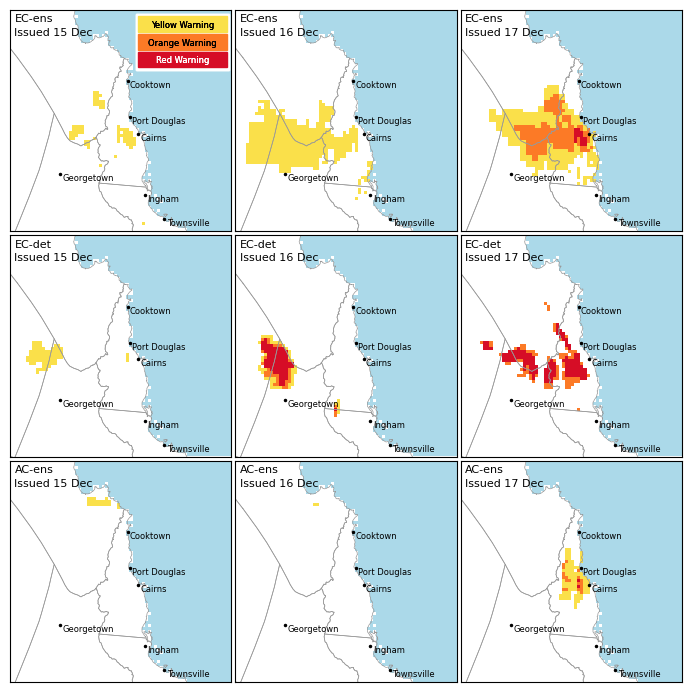

In [9]:
# Plot the warning maps
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(7, 7))

# color dictionary
col_dict = {
    -1: C_WATER,  # lightblue
    0: C_NIL,
    1: C_YELLOW,
    2: C_ORANGE,
    3: C_RED,
}

# We create a colormar from our list of colors
cm = ListedColormap([col_dict[x] for x in col_dict.keys()])

# prepare normalizer
# Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

# Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len(col_dict), clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

for fcst, model, ax_row in zip([ecens, ecdet, acens], ['EC-ens', 'EC-det', 'AC-ens'], [0, 1, 2]):
    for leadday, ax_col, scaling in zip([2, 1, 0], [0, 1, 2], [DAY2_SCALING, DAY1_SCALING, DAY0_SCALING]):
        
        da_warning = get_warning_map_values(fcst, leadday, aeps_gridded, SEV_THRESHOLDS, PROB_THRESHOLDS, scaling)
        axs[ax_row,ax_col].pcolormesh(
            da_warning.projection_x_coordinate.values, da_warning.projection_y_coordinate.values, da_warning.values,
            cmap=cm, norm=norm
        )
        
        # add public weather districts
        for shape in sf.shapeRecords():
            for i in range(len(shape.shape.parts)):
                i_start = shape.shape.parts[i]
                if i==len(shape.shape.parts)-1:
                    i_end = len(shape.shape.points)
                else:
                    i_end = shape.shape.parts[i+1]
                y = [i[0] for i in shape.shape.points[i_start:i_end]]
                x = [i[1] for i in shape.shape.points[i_start:i_end]]
                x, y = mf.latlon_to_albers(np.array(x), np.array(y))
                axs[ax_row,ax_col].plot(x, y, color='#999999', linewidth=.5)

        # clip to domain of interest
        axs[ax_row,ax_col].set_xlim(*XLIMS)
        axs[ax_row,ax_col].set_ylim(*YLIMS)

        axs[ax_row,ax_col].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False
        )
        axs[ax_row,ax_col].tick_params(
            axis='y',          # changes apply to the y-axis
            which='both',      # both major and minor ticks are affected
            left=False,      # ticks along the bottom edge are off
            right=False,         # ticks along the top edge are off
            labelleft=False
        )

        # add place names
        # first get lat lon of places in projection coordinates
        places_x, places_y = mf.latlon_to_albers(PLACES['lat'], PLACES['lon'])
        axs[ax_row,ax_col].plot(places_x, places_y, marker='.', c='black', markersize=3, linestyle='None', label='Points')
        for i in range(len(places)):
            axs[ax_row,ax_col].text(
                places_x[i] + place_label_x_delta, places_y[i], places['name'][i], 
                fontsize=6, horizontalalignment="left", verticalalignment="top"
            )
            
        

        # add details of model and lead day
        axs[ax_row,ax_col].text(
            mf.get_pos(.02, XLIMS), mf.get_pos(.98, YLIMS), model,
            fontsize=8, horizontalalignment="left", verticalalignment="top"
        )
        axs[ax_row,ax_col].text(
            mf.get_pos(.02, XLIMS), mf.get_pos(.92, YLIMS), f'Issued {17-leadday} Dec',
            fontsize=8, horizontalalignment="left", verticalalignment="top"
        )

    add_legend(axs[0,0], fontsize=6, rect_length=.4, rect_x_pos=0.58)


fig.subplots_adjust(bottom=0.02, top=0.98, left=0.02, right=0.98, wspace=0.02, hspace=0.02)


plt.show()